In [70]:
import pandas as pd, numpy as np, seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import poisson, gamma, expon, binom, norm
from scipy.stats import gaussian_kde
from utils import *

sns.set_style("whitegrid")

Wants to arrive on P[y|D]

where **y** is the wait time, and **D** is # of passangers waiting at the station

We don't know the wait time explictly; thus we need to derive it through z = x + y.

Where z = train arrival interval times | x = elapse time from last arrival train -> y = z - x

In addition, Data that passangers arrival follows poission distribution with lambda=2/min, and now it has 10 guys

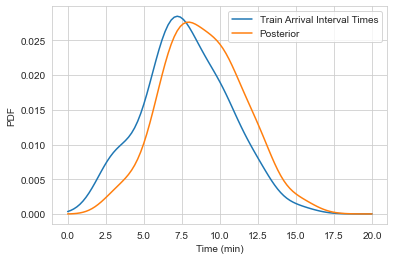

In [71]:
# observed time arrival interval data
observed_gap_times = np.array([
    428.0, 705.0, 407.0, 465.0, 433.0, 425.0, 204.0, 506.0, 143.0, 351.0, 
    450.0, 598.0, 464.0, 749.0, 341.0, 586.0, 754.0, 256.0, 378.0, 435.0, 
    176.0, 405.0, 360.0, 519.0, 648.0, 374.0, 483.0, 537.0, 578.0, 534.0, 
    577.0, 619.0, 538.0, 331.0, 186.0, 629.0, 193.0, 360.0, 660.0, 484.0, 
    512.0, 315.0, 457.0, 404.0, 740.0, 388.0, 357.0, 485.0, 567.0, 160.0, 
    428.0, 387.0, 901.0, 187.0, 622.0, 616.0, 585.0, 474.0, 442.0, 499.0, 
    437.0, 620.0, 351.0, 286.0, 373.0, 232.0, 393.0, 745.0, 636.0, 758.0,
])

# constructing prior belief using gaussian kde at 100 data points
zqs = np.linspace(0, 20, 101)
zprior = fit_gaussian_kde_pmf(observed_gap_times/60, zqs)

# The above data is the actual reported arrival interval
# for one to experience one of the interval, [inspection paradox]
# the probability is higher proportional to the interval lengeth
# thus the posterior update is simple. Below is the someone would experiences
zposterior = normalize_dist(zprior * zprior.index.values)

zprior.plot(label='Train Arrival Interval Times')
zposterior.plot(label='Posterior')
plt.xlabel('Time (min)')
plt.ylabel('PDF')
_ = plt.legend()
plt.show()

Elapse Mean 4.45 5.14


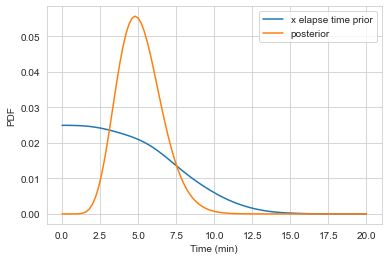

In [72]:
# elapse time x is equally likely at any time points for a given known train interval y
# thus, x follows uniform distribution with respect to y -> U[0, y]
# So, x distribution can be constructed by going through all possibile ys [train arrival interval] -> then mixed up
xdist_lst = [make_uniform_dist(zposterior.loc[:i].index.values) for i in zposterior.index.values]
xprior = mix_dist(*xdist_lst, ps=zposterior.values)

# here the likelihood is calculated with the given data, that there are 10 people at the station
# and the arrival process follows poisson distribution with lambda = 2/min
# so if x minutes passed, the mean of poisson = 2x for calculation
lam, k = 2, 10 
likelihood = poisson(mu=lam*xprior.index.values).pmf(k=k)
xposterior = normalize_dist(xprior * likelihood)


xprior.plot(label='x elapse time prior')
xposterior.plot(label='posterior')

print('Elapse Mean {:.2f} {:.2f}'.format(dist_mean(xprior), dist_mean(xposterior)))
plt.xlabel('Time (min)')
plt.ylabel('PDF')
_ = plt.legend()
plt.show()

Avg Wait Time = 4.41 mins


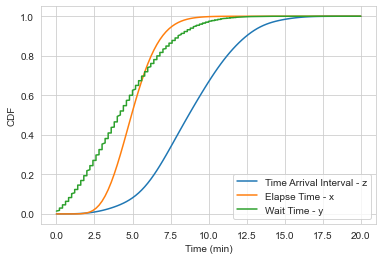

In [75]:
xposterior_neg = xposterior.copy()
xposterior_neg.index = xposterior_neg.index*-1  # nice little substraction trick

# y = z - x
yposterior = add_dist(*[zposterior, xposterior_neg])  # order matters here
yposterior = normalize_dist(yposterior[yposterior.index >= 0])

print('Avg Wait Time = {:.2f} mins'.format(dist_mean(yposterior)))
zposterior.cumsum().plot(label='Time Arrival Interval - z')
xposterior.cumsum().plot(label='Elapse Time - x')
yposterior.cumsum().plot(label='Wait Time - y')

plt.xlabel('Time (min)')
plt.ylabel('CDF')
_ = plt.legend()
plt.show()

In [68]:
# do Z prior & posterior
np.random.seed(873498579)
ydata = list(np.random.choice(observed_gap_times, size=260, replace=True) / 60)
ydata = np.append(ydata, [30, 40, 50])
zqs = np.linspace(0, 60, 101)
zprior = fit_gaussian_kde_pmf(ydata, zqs)
zposterior = normalize_dist(zprior * zprior.index.values)

# do X prior
xdist_lst = [make_uniform_dist(zposterior.loc[:i].index.values) for i in zposterior.index.values]
xprior = mix_dist(*xdist_lst, ps=zposterior.values)

def compute_yposterior(k, lam=2):
    # do X posterior
    likelihood = poisson(mu=lam*xprior.index.values).pmf(k=k)
    xposterior = normalize_dist(xprior * likelihood)

    # do Z
    xposterior_neg = xposterior.copy()
    xposterior_neg.index = xposterior_neg.index*-1
    yposterior = add_dist(*[zposterior, xposterior_neg])
    yposterior = normalize_dist(yposterior[yposterior.index >= 0])
    return yposterior


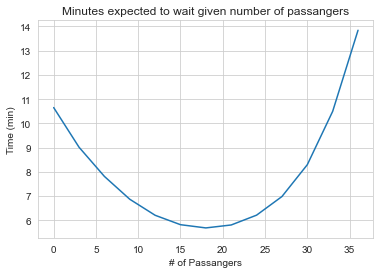

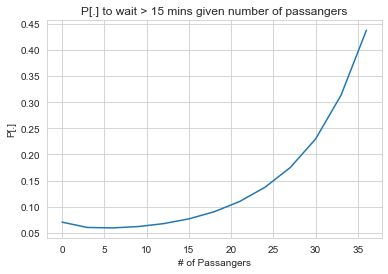

In [69]:
# for decision analysis
# we relax the orignal data (lam=2, 10 passanger)
# to construct wait time y in respect all spectrum of possible data
knums = np.arange(0, 37, 3)
ypost_lst = [compute_yposterior(k=k, lam=2) for k in knums]

mu_wait = [dist_mean(a) for a in ypost_lst]

plt.plot(knums, mu_wait)
plt.title('Minutes expected to wait given number of passangers')
plt.xlabel('# of Passangers')
plt.ylabel('Time (min)')
plt.show()

gt15_wait = [a[a.index>15].sum() for a in ypost_lst]

plt.plot(knums, gt15_wait)
plt.title('P[.] to wait > 15 mins given number of passangers')
plt.xlabel('# of Passangers')
plt.ylabel('P[.]')
plt.show()